# Causal Inference: Forests

## Set Up Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_ipcw, brier_score
from sksurv.util import Surv
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'sksurv'

## Reading in Data

In [ ]:
data = pd.read_csv("rhc_imputed.csv")
data.head(5)
data.describe()

# RSF Survival Analysis with ATE/CATE + Metrics

### Cleaning and Setting Variables

In [5]:
# Dropping NAs
data_clean = data.dropna(subset=["SurvivalTime", "death"])

# Treatment indicator (W = 1 if RHC, W = 0 if no RHC)
W = data_clean["swang1"].astype(int)

# Outcome Y (survival time)
Y = data_clean["SurvivalTime"].values

# Event type (D = 1 if true/dead, D = 0 if false/censored)
D = data_clean["death"].astype(bool).values

# Define covariates for model
exclude = ["ptid", "swang1", "dthdte", "dschdte", "lstctdte", "sadmdte",
           "survtime", "death", "SurvivalTime", "censor", "dth30", "t3d30"]
X_temp = data_clean.drop(columns=[col for col in exclude if col in data_clean.columns])
X = pd.get_dummies(X_temp, drop_first=True)

### Setting Horizons: 30, 90, ~180 days

In [6]:
eval_times = np.array([30., 90., 179.])
times_all = np.linspace(0, 179, 180)

### Cross-Validation: 5-Fold, Using Survival Probability

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_folds = {t: [] for t in eval_times}
brier_folds = {t: [] for t in eval_times}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    W_train, W_test = W.iloc[train_index], W.iloc[test_index]
    
    y_train_arr = np.array(list(zip(Y[train_index], D[train_index])), dtype=[('event_time', 'f8'), ('event', 'bool')])
    y_test_arr = np.array(list(zip(Y[test_index], D[test_index])), dtype=[('event_time', 'f8'), ('event', 'bool')])
    
    y_train = Surv.from_arrays(y_train_arr['event'], y_train_arr['event_time'])
    y_test = Surv.from_arrays(y_test_arr['event'], y_test_arr['event_time'])

    # RSF: T-Learner Training (two separate models)
    rsf_control = RandomSurvivalForest(n_estimators=200, min_samples_leaf=15, n_jobs=-1, random_state=42)
    rsf_control.fit(X_train[W_train == 0], y_train[W_train == 0])

    rsf_treat = RandomSurvivalForest(n_estimators=200, min_samples_leaf=15, n_jobs=-1, random_state=42)
    rsf_treat.fit(X_train[W_train == 1], y_train[W_train == 1])

    # Predict Survival Probabilities
    surv_funcs_treat = rsf_treat.predict_survival_function(X_test)
    surv_funcs_control = rsf_control.predict_survival_function(X_test)

    surv_probs_treat = np.row_stack([fn(eval_times) for fn in surv_funcs_treat])
    surv_probs_control = np.row_stack([fn(eval_times) for fn in surv_funcs_control])

    W_test_array = np.asarray(W_test)

    for i, t in enumerate(eval_times):
        surv_probs_obs = np.where(W_test_array == 1, surv_probs_treat[:, i], surv_probs_control[:, i])
        c_idx = concordance_index_ipcw(y_train, y_test, 1 - surv_probs_obs, t)[0]
        bs = brier_score(y_train, y_test, surv_probs_obs.reshape(-1, 1), np.array([t]))[1][0]
        c_index_folds[t].append(c_idx)
        brier_folds[t].append(bs)

In [8]:
print("\n Cross-Validated Evaluation Metrics")
for t in eval_times:
    print(f"\nTime = {int(t)} days")
    print(f"C-index: {np.mean(c_index_folds[t]):.4f} ± {np.std(c_index_folds[t]):.4f}")
    print(f"Brier Score: {np.mean(brier_folds[t]):.4f} ± {np.std(brier_folds[t]):.4f}")


 Cross-Validated Evaluation Metrics

Time = 30 days
C-index: 0.7363 ± 0.0078
Brier Score: 0.1814 ± 0.0065

Time = 90 days
C-index: 0.7245 ± 0.0069
Brier Score: 0.1961 ± 0.0026

Time = 179 days
C-index: 0.7159 ± 0.0058
Brier Score: 0.2007 ± 0.0012


** Note: reliable models should have Brier score below 0.25

** Note: C-index of 0.5 is random chance

### Generating Model: T-learner, using two models (treated, control), RMST

In [9]:
rsf_control = RandomSurvivalForest(n_estimators=200, min_samples_leaf=15, n_jobs=-1, random_state=42)
rsf_control.fit(X[W == 0], Surv.from_arrays(D[W == 0], Y[W == 0]))

rsf_treat = RandomSurvivalForest(n_estimators=200, min_samples_leaf=15, n_jobs=-1, random_state=42)
rsf_treat.fit(X[W == 1], Surv.from_arrays(D[W == 1], Y[W == 1]))

surv_funcs_treat_all = rsf_treat.predict_survival_function(X)
surv_funcs_control_all = rsf_control.predict_survival_function(X)

sp_t_all = np.row_stack([fn(times_all) for fn in surv_funcs_treat_all])
sp_c_all = np.row_stack([fn(times_all) for fn in surv_funcs_control_all])

rmst_t = np.trapz(sp_t_all, x=times_all, axis=1)
rmst_c = np.trapz(sp_c_all, x=times_all, axis=1)

### ATE and CATE (Using RMST)

In [10]:
CATE_rmst = rmst_t - rmst_c
ATE_rmst = np.mean(CATE_rmst)
print(f"\nAverage Treatment Effect (RMST to 179 days): {ATE_rmst:.4f}")


Average Treatment Effect (RMST to 179 days): -10.9690


### CART on CATE

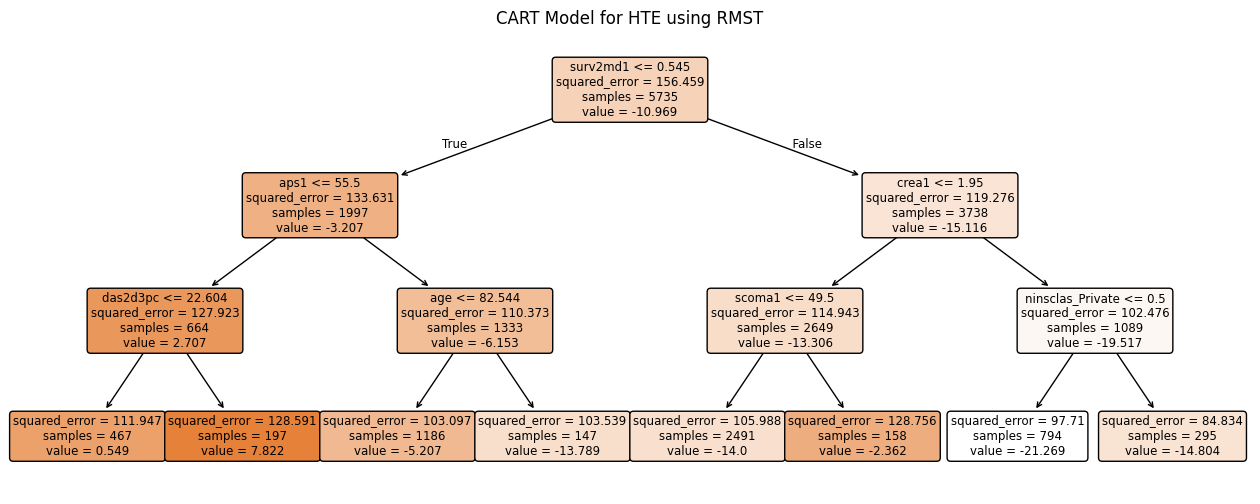

In [11]:
cart = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)
cart.fit(X, CATE_rmst)

plt.figure(figsize=(16, 6))
plot_tree(cart, feature_names=X.columns, filled=True, rounded=True)
plt.title("CART Model for HTE using RMST")
plt.show()

### Feature Importance

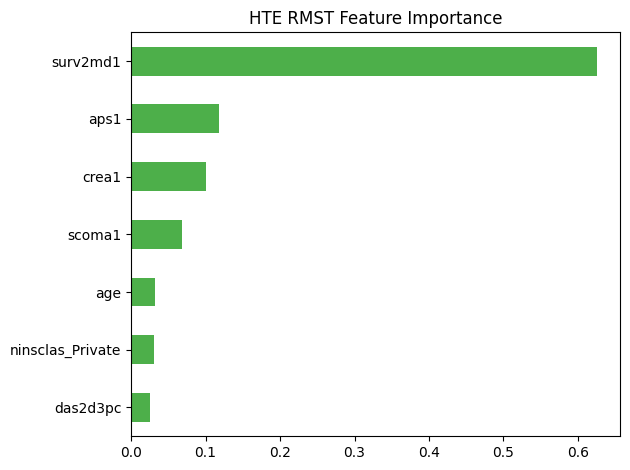

In [12]:
importances = pd.Series(cart.feature_importances_, index=X.columns)
importances = importances[importances > 0].sort_values()
importances.plot(kind="barh", title="HTE RMST Feature Importance", color="#4daf4a")
plt.tight_layout()
plt.show()

### CATE Distribution

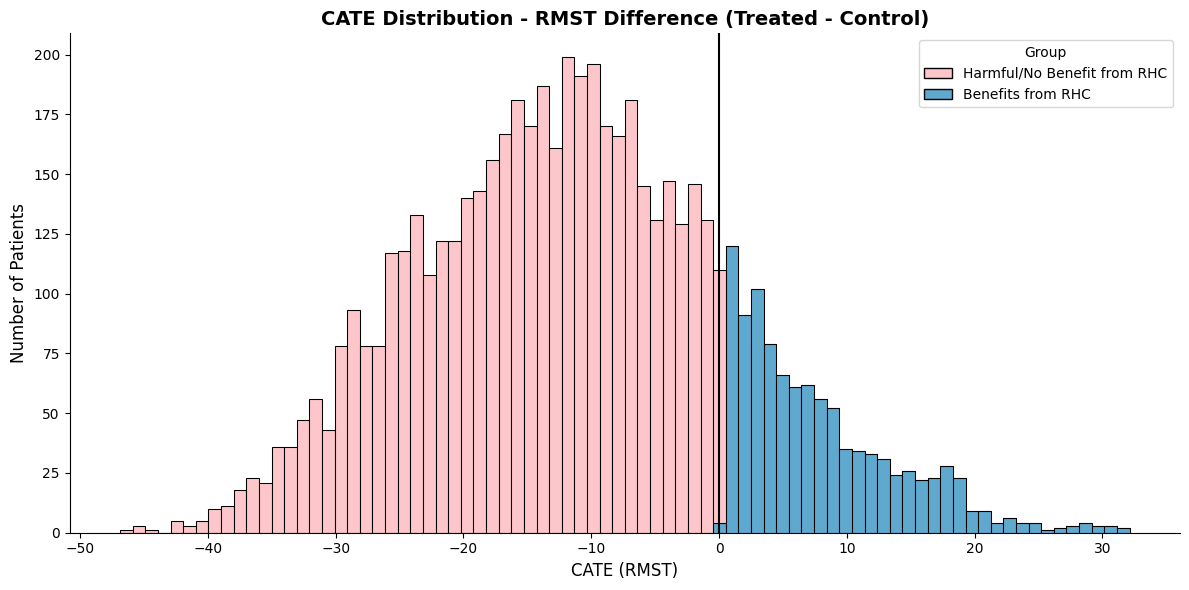

In [14]:
df_cate = pd.DataFrame({
    "CATE_RMST": CATE_rmst,
    "Group": np.where(CATE_rmst > 0.5, "Benefits from RHC", "Harmful/No Benefit from RHC")
})

plt.figure(figsize=(12, 6))
sns.histplot(data=df_cate, x="CATE_RMST", hue="Group", bins=80,
             palette={"Benefits from RHC": "#2b8cbe", "Harmful/No Benefit from RHC": "#fbb4b9"},
             multiple="stack")
plt.axvline(0, color="black")
plt.title("CATE Distribution - RMST Difference (Treated - Control)", fontsize=14, weight="bold")
plt.xlabel("CATE (RMST)", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

### Saving files

In [16]:
df_rmst_effects = pd.DataFrame({
    "CATE_RMST": CATE_rmst,
    "RMST_Treat": rmst_t,
    "RMST_Control": rmst_c
})

df_rmst_effects.to_csv("cate_rmst_values.csv", index=False)